In [1]:

import os
import pdb
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import random
import ipdb

# Pipelines (a.k.a parts of the Neural Network)
from Pipelines.kitti_loader import KITTIDataset
from Pipelines.pillarizer import PillarFeatureNet, Pillarization, PseudoImageDataset
from Pipelines.backbone import BackBone
from Pipelines.detection_head import DetectionHead

# Visualization tools:
from Visualization.visz_pointcloud_w_label import plot_point_cloud_with_bboxes_o3d


print(f'Can I can use GPU now? -- {torch.cuda.is_available()}')


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Can I can use GPU now? -- True


Load data from the KITTI dataset and perform train-test split:


In [2]:
#train_pointclouds_full_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne'

train_pointclouds_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced'
train_labels_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/label_2'
test_pointclouds_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/testing/velodyne_reduced'

train_set = KITTIDataset(pointcloud_dir=train_pointclouds_dir, labels_dir=train_labels_dir)

# Neural Network Parameters:
AUG_DIM = 9
MAX_POINTS_PER_PILLAR = 100
MAX_FILLED_PILLARS = 12000
X_MIN = 0.0
X_MAX = 70.4
Y_MIN = -40.0
Y_MAX = 40.0
Z_MIN = -3.0
Z_MAX = 1.0
PILLAR_SIZE = (0.16, 0.16)

# TODO: Add Loader for test set (No labels)

Visualize a pointcloud with its annotations

In [3]:
# Example usage:
random_idx_sample = random.randint(0,7000)
point_cloud, labels = train_set[0]  # TODO: Is it necessary to rotate bounding box 90 deg?
geometries = plot_point_cloud_with_bboxes_o3d(point_cloud.numpy(), labels)

File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/006066.bin


/home/adlink/Documents/ECE-57000/ClassProject/github/PointPillars/Implementation/Pipelines/kitti_loader.py:50: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(point_cloud)


Batch data:

In [4]:
# IMPORTANT: Set to CPU for pillarization otherwise, expect GPU memory to overflow
device =  torch.device('cpu')

# Create a collate function to handle variable-sized labels:
def collate_batch(batch):
    point_clouds, annotations = zip(*batch)
    
    # Convert lists of point clouds and annotations into tensors
    point_clouds = torch.stack(point_clouds, dim=0)
    
    # Padding for variable-sized labels:
    max_annotations = max(len(a['Car']) for a in annotations)
    padded_annotations = []
    for a in annotations:
        # Pad each annotation to have max_annotations entries
        car_annotations = a['Car'] + [{}] * (max_annotations - len(a['Car']))
        padded_annotations.append({'Car': car_annotations})
    
    return point_clouds, padded_annotations

        
# Create the dataset and DataLoader
dataset = PseudoImageDataset(pointcloud_dir=train_pointclouds_dir, device=device, kitti_dataset=train_set, aug_dim=AUG_DIM, max_points_in_pillar=MAX_POINTS_PER_PILLAR,
                             max_pillars=MAX_FILLED_PILLARS, x_min=X_MIN, y_min=Y_MIN, z_min=Z_MIN, x_max = X_MAX, y_max=Y_MAX,
                             z_max = Z_MAX, pillar_size=PILLAR_SIZE)

train_loader = DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=collate_batch)


# Iterate through batches:  
for batch_idx, (pseudo_image, label) in enumerate(train_loader):
    break # TODO: Erase this and load the entire dataset

File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/006066.bin
Loading point cloud number 0
File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/004407.bin
Loading point cloud number 1
File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/002395.bin
Loading point cloud number 2
File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/005517.bin
Loading point cloud number 3


In [5]:
pseudo_image.size()

torch.Size([4, 64, 500, 440])

In [6]:
# After pillarization and batching, we can start using the GPU:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Backbone pipeline:

Text(0.5, 1.0, 'Features Summed Over Channels')

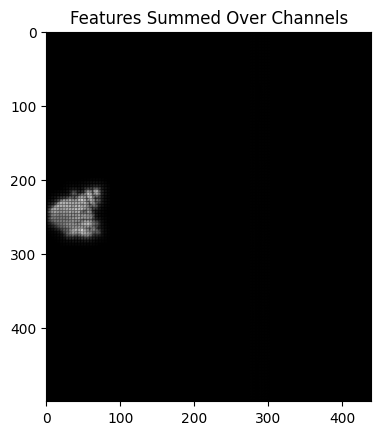

In [7]:
backbone = BackBone(in_channels=64, out_channels=64, device=device)
backbone_features = backbone(pseudo_image)


# Sum over channels for the original features
backbone_raw = torch.sum(backbone_features[3, :, :, :], dim=0).detach().numpy()
plt.imshow(backbone_raw, cmap='gray')
plt.title('Features Summed Over Channels')

In [8]:

# Forward pass through the backbone:
backbone = BackBone(in_channels=64, out_channels=64, device=device)
backbone_features = backbone(pseudo_image)


def transform_to_canvas(x_center, y_center, x_min, y_min, radius, pillar_size):
    x_center_img = (x_center - x_min) // pillar_size[0]
    y_center_img = (y_center - y_min) // pillar_size[1]
    radius_img = radius / pillar_size[0] # TODO: This assumes that pillar_size is the same in x and y
    return x_center_img, y_center_img, radius_img


def transform_to_grid(length, width, height, z_center, orientation, pillar_size):
    length_tr = length // pillar_size[0] # Assumes pillar size is equal in both dimensions
    width_tr = width // pillar_size[0]
    return length_tr, width_tr


def generate_anchors(x_c, y_c, r, anchor_dims, pillar_size):

    '''Generate anchors within the given radius based on the anchor dimensions
    and returns the list of anchors'''

    anchors = []

    for anchor_dim in anchor_dims:
        # Unpack the anchor dimensions
        length, width, height, z_center, orientation = anchor_dim

        length_tr, width_tr = transform_to_grid(length, width, height, z_center, orientation, pillar_size)
        # Create anchor:
        anchor_2d = (x_c, y_c, z_center, length, width, height, orientation)
        if (x_c - r <= x_c <= x_c + r) and (y_c - r <= y_c <= y_c + r):
            anchors.append(anchor_2d) # Append anchor
        
    return anchors




# Anchors as tensor: (length, width, height, z_center, orientation)
anchor_dims = torch.tensor([[3.9, 1.6, 1.56, -1, 0], # TODO: Declare at the top
                       [3.9, 1.6, 1.56, -1, 1.5708],
                       [0.8, 0.6, 1.73, -0.6, 0],
                       [0.8, 0.6, 1.73, -0.6, 1.5708]]
                       )


# Copy backbone features for visualization:
backbone_features_masked = backbone_features.detach().clone()

# TODO: For each 3D bounding box provided in the label files, a search radius is defined 
# around the original bounding box based on object dimensions (represented as a red circle in a grid).
for batch_index, gt_label in enumerate(label):
    if gt_label['Car'][0] == [{}]:
        continue
    
    # Create target radius:
    target_radii = []

    # Number of objects: 
    n_objects = len(gt_label['Car'])

    # Create empty tensor that holds target circles:
    target_circles = torch.zeros(n_objects, 3) # Tensor will hold (x_center, y_center and radius of the target circle for applying the anchors)


    margin = 2.0 # Adds to the box to get the target radius for SSD
    
    # Initialize the mask tensor for the current batch element
    mask = torch.zeros(backbone_features.size(-2), backbone_features.size(-1), dtype=torch.bool)


    # Iterate over targets to set target_radii and apply anchors
    for i in range(n_objects):
        if gt_label['Car'][i] == {}: # If true, done with target generation
            print('EMPTY')
            continue

        x_center = gt_label['Car'][i]['location'][2] # y, z, r
        y_center = gt_label['Car'][i]['location'][0]
        height = gt_label['Car'][i]['dimensions'][0]
        width = gt_label['Car'][i]['dimensions'][1]

        # TODO: Transform targets to pseudo_image_frame:
        target_radius = max(height, width) + margin
        # target_circles[i,0:3] = torch.tensor([x_center, y_center, target_radius]) DEPRECATE?

        # Ground-truth box in the canvas for IoU computations:
        x_center_tr, y_center_tr, target_radius_tr =  transform_to_canvas(x_center=x_center, 
            y_center=y_center, x_min=X_MIN, y_min=Y_MIN, radius=target_radius, pillar_size=PILLAR_SIZE)
        
        print(f'x center: {x_center_tr}')
        y, x = torch.meshgrid(torch.arange(backbone_features.size()[-2]), torch.arange(backbone_features.size()[-1]))
    
        # Generate mask for current target:
        mask |= (x - x_center_tr) ** 2 + (y - y_center_tr) ** 2 <= target_radius_tr ** 2

        # Generate anchors:
        anchors_2d = generate_anchors(x_c=x_center_tr, y_c=y_center_tr, r=target_radius_tr, 
            anchor_dims=anchor_dims, pillar_size=PILLAR_SIZE)
        
        for anchor_2d in anchors_2d:
            iou = calculate_iou(anchor, ground_truth_box)
            if iou >= IOU_THRESHOLD:
            # Calculate and record the target deltas for this anchor
            # Usually, the deltas are the differences between the anchor and the ground truth box
            # in terms of center coordinates, dimensions, and orientation (yaw angle)
            deltas = calculate_deltas(anchor, ground_truth_box)
            # You would then assign these deltas to a target tensor that your model would predict
                

        
        print(f'Anchors 2D: {anchors_2d}')

        # TODO: Get ground truth box:


    # After all circles have been drawn on the mask, expand it to cover the channel dimension
    expanded_mask = mask.unsqueeze(0).expand(backbone_features.size(1), -1, -1) 

    # Convert the mask to the same type as the backbone features to apply it
    expanded_mask = expanded_mask.to(backbone_features.dtype)

    backbone_features_masked[batch_index] *= expanded_mask
    





IndentationError: expected an indented block (3892204393.py, line 109)

In [43]:
anchors

[(445.0,
  434.0,
  tensor(-1.),
  tensor(3.9000),
  tensor(1.6000),
  tensor(1.5600),
  tensor(0.)),
 (445.0,
  434.0,
  tensor(-1.),
  tensor(3.9000),
  tensor(1.6000),
  tensor(1.5600),
  tensor(1.5708)),
 (445.0,
  434.0,
  tensor(-0.6000),
  tensor(0.8000),
  tensor(0.6000),
  tensor(1.7300),
  tensor(0.)),
 (445.0,
  434.0,
  tensor(-0.6000),
  tensor(0.8000),
  tensor(0.6000),
  tensor(1.7300),
  tensor(1.5708))]

In [ ]:
    # WARNING: THIS IS JUST FOR VISUALIZATION PURPOSES:

    # Sum over channels for the original features
    backbone_pre_sum = torch.sum(backbone_features[batch_index], dim=0).detach().numpy()

    # Sum over channels for the masked features
    backbone_pos_sum = torch.sum(backbone_features_masked[batch_index], dim=0).detach().numpy()


    # Visualization using matplotlib
    plt.figure(figsize=(12, 6))

    # Original feature visualization
    plt.subplot(1, 3, 1)
    plt.imshow(backbone_pre_sum, cmap='gray')
    plt.title('Original Features Summed Over Channels')

    # Masked feature visualization
    plt.subplot(1, 3, 2)
    plt.imshow(backbone_pos_sum, cmap='gray')
    plt.title('Masked Features Summed Over Channels')

    # Masked feature visualization
    plt.subplot(1, 3, 3)
    plt.imshow(mask.numpy(), cmap='gray')
    plt.title('Mask applied')

    plt.show()

    # TODO: Apply each anchor and get the anchor with the highest IoU:

In [9]:
backbone_features.size()


torch.Size([4, 384, 500, 440])

In [22]:
anchor_dims.size()[0]

4

Now, implement the Detection Head:

In [10]:
#backbone_output = torch.randn(4, backbone_features.size()[1], 252, 252) # Example feature map from backbone
detection_head = DetectionHead(device=device, in_channels=backbone_features.size()[1], grid_size_x=backbone_features.size()[2], 
                        grid_size_y=backbone_features.size()[3], num_anchors=4, num_classes=2) #TODO: Initialize with correct parameters
loc, size, clf, occupancy, angle, heading = detection_head(backbone_features)

In [11]:
loc.size()

torch.Size([4, 4, 3, 500, 440])

Create anchors for Single-Shot Detector:

In [ ]:
pseudo_image.size()

In [ ]:
max_labels

Previous version:

In [ ]:
backbone_features.size()

In [ ]:
anchor_dims

In [ ]:



# TODO: createPillarsTarget function: This function is tasked with generating regression targets, which are 
# essential for subsequent loss value calculations. It follows these steps:


# TODO: For each 3D bounding box provided in the label files, a search radius is defined 
# around the original bounding box based on object dimensions (represented as a red circle in a grid).
for gt_label in label:
    if gt_label['Car'] == [{}, {}, {}, {}, {}, {}, {}]:
        continue

    # Create target radius:
    target_radii = []

    # Number of objects: 
    n_objects = len(gt_label['Car'])

    # Create empty tensor that holds target circles:
    target_circles = torch.zeros(n_objects, 3) # Tensor will hold (x_center, y_center and radius of the target circle for applying the anchors)

    # Iterate over targets to set target_radii and apply anchors
    for i in range(n_objects):
        if gt_label['Car'][i] == {}:
            n_objects = i
            break

        #target_radii.append(TargetRadius(x_center=gt_label['Car'][i]['location'][2], 
        #                        y_center=gt_label['Car'][i]['location'][0], radius=6.0))
        x_center = gt_label['Car'][i]['location'][2]
        y_center = gt_label['Car'][i]['location'][0]
        height = gt_label['Car'][i]['dimensions'][0]
        width = gt_label['Car'][i]['dimensions'][1]

        target_radius = max(height, width)
        target_circles[i,0:3] = torch.tensor([x_center, y_center, target_radius])


In [ ]:
label

Now, create the loss function:

In [ ]:

class PointPillarLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(PointPillarLoss, self).__init__()
        self.smooth_l1_loss = nn.SmoothL1Loss()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, predictions, targets):
        # Unpack predictions and targets
        pred_boxes, pred_scores = predictions
        gt_boxes, gt_scores = targets
        
        # Calculate the residuals for the boxes
        da = torch.sqrt((pred_boxes[:, 3] - pred_boxes[:, 0])**2 + (pred_boxes[:, 4] - pred_boxes[:, 1])**2)
        dx = (gt_boxes[:, 0] - pred_boxes[:, 0]) / da
        dy = (gt_boxes[:, 1] - pred_boxes[:, 1]) / da
        dz = (gt_boxes[:, 2] - pred_boxes[:, 2]) / pred_boxes[:, 5]
        dw = torch.log(gt_boxes[:, 3] / pred_boxes[:, 3])
        dl = torch.log(gt_boxes[:, 4] / pred_boxes[:, 4])
        dh = torch.log(gt_boxes[:, 5] / pred_boxes[:, 5])
        dtheta = torch.sin(gt_boxes[:, 6] - pred_boxes[:, 6])
        
        # Stack the residuals
        residuals = torch.stack((dx, dy, dz, dw, dl, dh, dtheta), dim=1)
        
        # Calculate the SmoothL1 loss for localization
        loc_loss = self.smooth_l1_loss(pred_boxes, residuals)
        
        # Calculate the Focal loss for classification
        p = torch.sigmoid(pred_scores)
        pt = p * gt_scores + (1 - p) * (1 - gt_scores)  # p_t
        alpha_t = self.alpha * gt_scores + (1 - self.alpha) * (1 - gt_scores)
        cls_loss = -alpha_t * (1 - pt) ** self.gamma * (gt_scores * torch.log(p) + (1 - gt_scores) * torch.log(1 - p))
        
        # Sum up the localization and classification losses
        total_loss = loc_loss + cls_loss.sum()
        
        return total_loss

# Example usage:
model = ...  # Your model here
criterion = PointPillarLoss()

# Predictions from the model
pred_boxes = ...  # Your predicted boxes here (Nx7)
pred_scores = ...  # Your predicted scores here (Nx1)

# Targets
gt_boxes = ...  # Your ground truth boxes here (Nx7)
gt_scores = ...  # Your ground truth scores here (Nx1)

# Compute the loss
loss = criterion((pred_boxes, pred_scores), (gt_boxes, gt_scores))

